In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import KDTree
import cv2

import sys
sys.path.append('../')

from skeletor.utils import courseGrainField

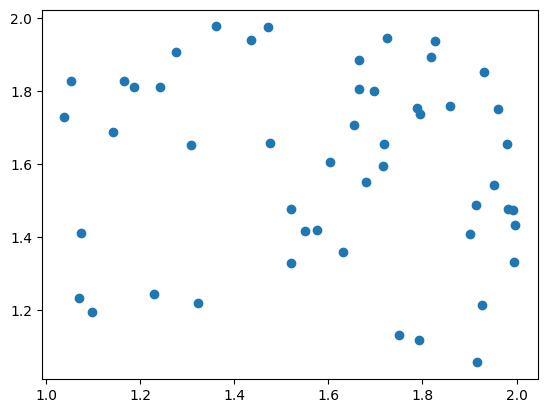

In [73]:
points = np.random.uniform(1, 2, size=(50,2))

plt.scatter(*points.T)
plt.show()

[1.03903813 1.05571556]


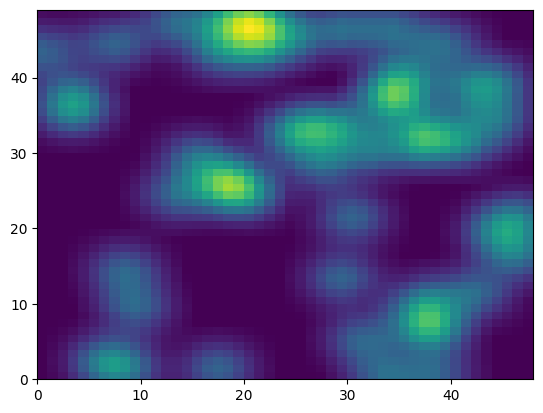

In [85]:
latticeSpacing = .02
field, corner = courseGrainField(points, latticeSpacing=latticeSpacing, kernelSize=11, returnCorner=True)
print(corner)
plt.pcolor(field)
plt.show()

In [89]:
def pathIntegralAlongField(field, path, latticeSpacing=1, fieldOffset=None):
    """
    Computes the path integral along a scalar discretized field in any
    dimension.

    Uses linear interpolation along the path, so works the best for smoothly-
    varying fields.

    Does not interpolate the steps along the path, so the input path steps
    should be appropriately broken up.

    Make sure that all of the quantities passed to this method use the same
    ordering of dimensions! For example, if you are integrating across an
    image, these often use y-x convention, whereas you may be tempted to
    put your path information in x-y format.
    
    Parameters
    ----------
    field : numpy.ndarray[N,M,...]
        Field over which to compute the path integral.

    path : numpy.ndarray[L,d]
        L ordered points representing a path
        through the field.

    latticeSpacing : float, or numpy.ndarray[d]
        The lattice spacing for the discretized field;
        can be a single value for all dimensions, or different
        values for each dimension.

    fieldOffset : numpy.ndarray[d] or None
        The position of the bottom left corner
        of the discrete lattice on which the field exists.

    Returns
    -------
    result : float
    """
    # Scale the path to have no units
    scaledPath = path.astype(np.float64)
    
    if fieldOffset is not None:
        scaledPath -= fieldOffset
    
    scaledPath /= latticeSpacing

    # Generate the lattice positions that our field is defined on
    axes = [np.arange(d) for d in np.shape(field)]
    points = np.array(np.meshgrid(*axes, indexing='ij')).T
    points = points.reshape(np.product(points.shape[:-1]), points.shape[-1])
    
    # Generate a kdtree of our lattice points to detect the closest ones for
    # interpolation
    kdTree = KDTree(points)
    # Search for points within the distance of 1 lattice spacing
    # This guarantees that you won't interpolate from points that
    # conflict with each other.
    interpolationPoints = kdTree.query_ball_point(scaledPath, 1+1e-5)
    fieldValuesAlongPath = np.zeros(len(scaledPath))
    
    for i in range(len(scaledPath)):
        localPoints = interpolationPoints[i]
        # Compute distances to each nearby point
        localDistances = [np.sqrt(np.sum((scaledPath[i] - points[j])**2)) for j in localPoints]
        interpolationContributions = localDistances / np.sum(localDistances)
        fieldValuesAlongPath[i] = np.sum(interpolationContributions * np.array([field[tuple(l)] for l in points[localPoints]]))

    # We need to weigh our numerical integration by the step size
    # We just to do a centered step scheme. ie. the interpolated value computed
    # above for point i "counts" for half of the path approaching point i, and
    # half of the path leaving point i. Thus, the first and last point are weighed
    # only half, since they don't have an incoming or outgoing path each.
    # We also have to scale back to the original lattice spacing.
    pathSpacings = np.sqrt(np.sum(((scaledPath[1:] - scaledPath[:-1])/latticeSpacing)**2, axis=-1))
    symSpacing = (pathSpacings[:-1] + pathSpacings[1:])/2
    symSpacing = np.concatenate(([pathSpacings[0]/2], symSpacing, [pathSpacings[-1]/2]))

    pathIntegral = np.sum(symSpacing*fieldValuesAlongPath)

    # plt.imshow(field) # imshow reverses reads y,x, while the other two do x,y
    # plt.scatter(*points.T[::-1], s=1, c='white')
    # plt.plot(*scaledPath.T[::-1], '-o', c='red', markersize=2)
    # plt.show()
    
    return pathIntegral

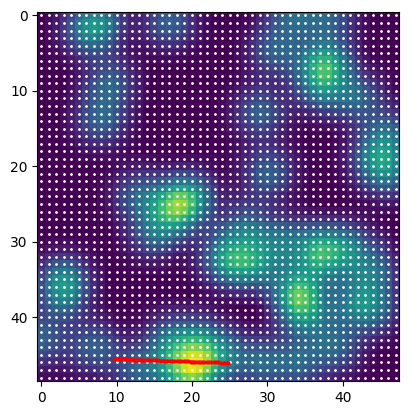

42.649309703599

In [84]:
path = np.array([1.95, 1.25]) + np.array([x*np.array([.01, .3]) for x in np.linspace(0, 1, 50)])

pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner)

In [107]:
# points = np.random.uniform(1, 2, size=(500,3))

# latticeSpacing = .02
# field, corner = courseGrainField(points, latticeSpacing=latticeSpacing, kernelSize=11, returnCorner=True)
# print(corner)

path = np.array([1.1, 1.1, 1.1]) + np.array([x*np.array([.8, .8, .8]) for x in np.linspace(0, 1, 50000)])

pathIntegralAlongField(field, path, latticeSpacing=latticeSpacing, fieldOffset=corner)

7.8332449148386765